In [1]:
import numpy as np
import yaml

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import os
from together import Together
%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter
import operator as op


## Section 1: Existing CVs data analysis

Here is a recent collection of CVs from https://github.com/Stereotypes-in-LLMs/recruitment-dataset 
We will use these CVs as the basis for generating cover letters for our hiring model

In [3]:
df = pd.read_parquet('data/resumes.parquet', engine='pyarrow')
# top 10 positions in resume database
newdf = df.dropna().groupby("Position").count().sort_values("Moreinfo", ascending=False).head(20)

In [4]:
top_twenty_jobs = list(newdf.index)

In [5]:
position = "Project Manager"
pm_occupation_df = df[df["Position"]==position]

In [6]:
# example entry 
pm_occupation_df.iloc[0].to_dict()

{'Position': 'Project Manager',
 'Moreinfo': '01.2020 - 04.2020\r\nProject manager/Account manager\r\n1. Working as a PM was responsible for project planning, resource planning, business communication, upsales.\r\n2. As an AM was involved in Outsataff projects monitoring and support. A few of the main responsibilities were to make research and investigate customer development processes and approaches resulting in advisory improvement strategies. Together with Sales manager took part in the upsales initiatives, finding out suitable upsales positions, profitable both for the client and company.\r\n\r\n06.2018 - 01.2020\r\nProject manager\r\nAs a Project Manager, I was responsible for projects estimation to match customers expectations and budget; was involved in resource management;  took the initiatives to make roadmaps planning together with the team; worked with risks; kept up team activities on control, to set the development process on track and up to the schedule; took the project 

) missing from current font./site-packages/IPython/core/events.py:89: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font./site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


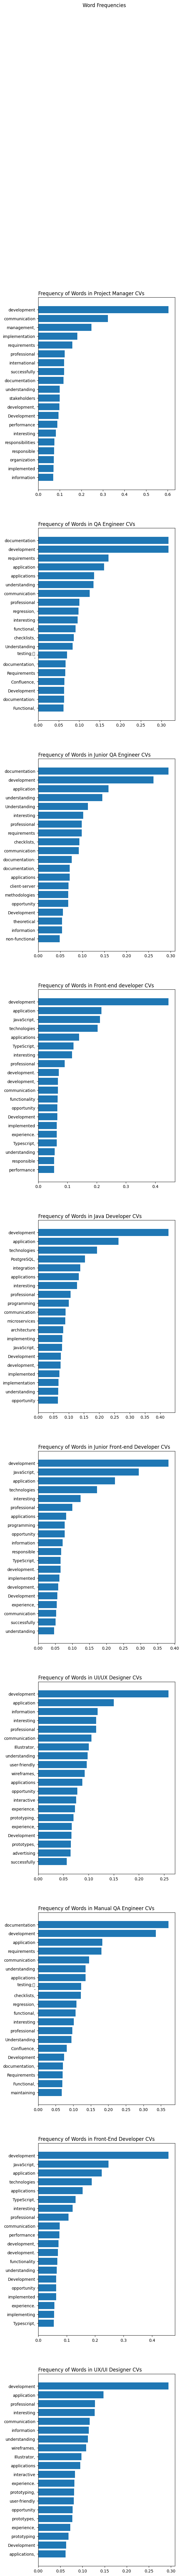

In [9]:
## TODO: further explorations of CV data, bring 2-3 insights about the CV itself and Insights and highlights

#First: What words are used more? Collaboration base Terms or Technical terms?

def plot_position_words(position):
    pm_occupation_df = df[df["Position"]==position]
    all_cvs = "\n".join(list(pm_occupation_df['CV']))
    all_words = all_cvs.split(" ")
    all_long_words = [word for word in all_words if len(word) > 10]
    word_counts = Counter(all_long_words)
    top_ten = word_counts.most_common(20)
    words =  [item[0] for item in top_ten]
    counts = [item[1]/len(pm_occupation_df) for item in top_ten]
    #fig, ax = plt.subplots(figsize =(10, 6))
    return [words, counts]
    # Horizontal Bar Plot
    #ax.barh(words, counts)
    #ax.set_title('Frequency of Words in ' + position + " CVs",loc ='left', )
    #ax.invert_yaxis()
 
#plot_position_words("Java Developer")

fig, axs = plt.subplots(len(top_twenty_jobs)-10, figsize=(6, 100))
fig.suptitle('Word Frequencies')
for i in range(0, len(top_twenty_jobs)-10):
    axs[i].set_title('Frequency of Words in ' + top_twenty_jobs[i] + " CVs",loc ='left', )
    axs[i].invert_yaxis()
    axs[i].barh(plot_position_words(top_twenty_jobs[i])[0], plot_position_words(top_twenty_jobs[i])[1])


## Section 2: Prompting LLMs for generating cover letters 

Now we will use a generic prompt to generate a cover letters for each resume using API calls

In [7]:
# Load the YAML file
with open('llm_api_keys.yaml', 'r') as file:
    config = yaml.safe_load(file)

together_api_key = config['services']['together']['api_key'] # replace with openai or anthropic also in yaml file

In [14]:
# example usage of Together AI 

client = Together(api_key=together_api_key) 

response = client.chat.completions.create(
    model="mistralai/Mixtral-8x7B-Instruct-v0.1",
    messages=[{"role": "user", "content": "write a cover letter for a project manager"}],
)
coverletter = response.choices[0].message.content

In [15]:
print(coverletter)

 Dear Hiring Manager,

I am writing to apply for the position of Project Manager at [Company Name]. With my extensive experience in project management, strong leadership skills, and proven track record of delivering projects on time and within budget, I am confident that I would be a valuable addition to your team.

In my current role as a Project Manager at [Current Company Name], I have successfully managed multiple projects simultaneously, ranging from software development to infrastructure deployment. I have experience working with cross-functional teams, including developers, designers, and stakeholders, to ensure that projects are delivered to the highest standards.

My experience in Agile project management methodologies, such as Scrum and Kanban, has enabled me to effectively manage project timelines, resources, and risks. I am also proficient in project management tools such as Jira, Trello, and Microsoft Project.

One of my greatest strengths is my ability to communicate effe

In [13]:
# TODO: 

# decide on a prompt and use prompt + CVs to generate cover letters 

## Section 3: Training a simple hiring model 

We will now use fast text to create a hiring model which will make a binary decision of whether we should hire a candidate or not based on years of experience as the ground truth. Fasttext (https://fasttext.cc/) is an easy to use library you can run on your local computer to build text classification models or get embedding representations for different inputs. Here we will use Fast text to generate embeddings and then use a logistic classifier on top of it. 

### Step 1: Generate embeddings from cover letters 

In [18]:
import fasttext
# load fast text vectors
ft = fasttext.load_model('../common/fasttext/cc.en.300.bin') # replace with your own path to the vector binary

In [20]:
def get_vector_rep(text): 
    tokens = text.lower().split() # feel free to use other tokenizations if you want
    for i, t in enumerate(tokens):
        if i == 0:
            vec = ft.get_word_vector(t)
        else:
            vec += ft.get_word_vector(t)
    return vec

In [21]:
vector_rep = get_vector_rep(coverletter)

In [22]:
# TODO: build vector embeddings and lables for positive label examples experience more than 5 years, negative examples less than 5

### Step 2: Build classifier for resume classification

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [26]:
x = # Fill in 
y = # Fill in

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

clf = LogisticRegression()
clf.fit(x_train, y_train)

p = clf.predict_proba(x_test)[:, 1]
p_acc = accuracy_score(y_test, p > 0.5)
print("clf_acc", p_acc) # ideally about 0.75, dont forget to check types of errors (e.g. confusion matrix)

SyntaxError: invalid syntax (995344463.py, line 1)

## Section 4: Simulation manipulations and evaluate disparity 

In [27]:
# TODO: which all the tools above, use several different models to generate coverletters to be classified with the hiring model

In [ ]:
# TODO: do all the modified resumes reach the threshold for classification as hire/interview? 